02:18:18 - cmdstanpy - INFO - Chain [1] start processing
02:18:18 - cmdstanpy - INFO - Chain [1] done processing



### Métricas ###
  Métrica        Valor
0     MAE  1506.239476
1    RMSE   2145.58081
2   sMAPE       84.00%


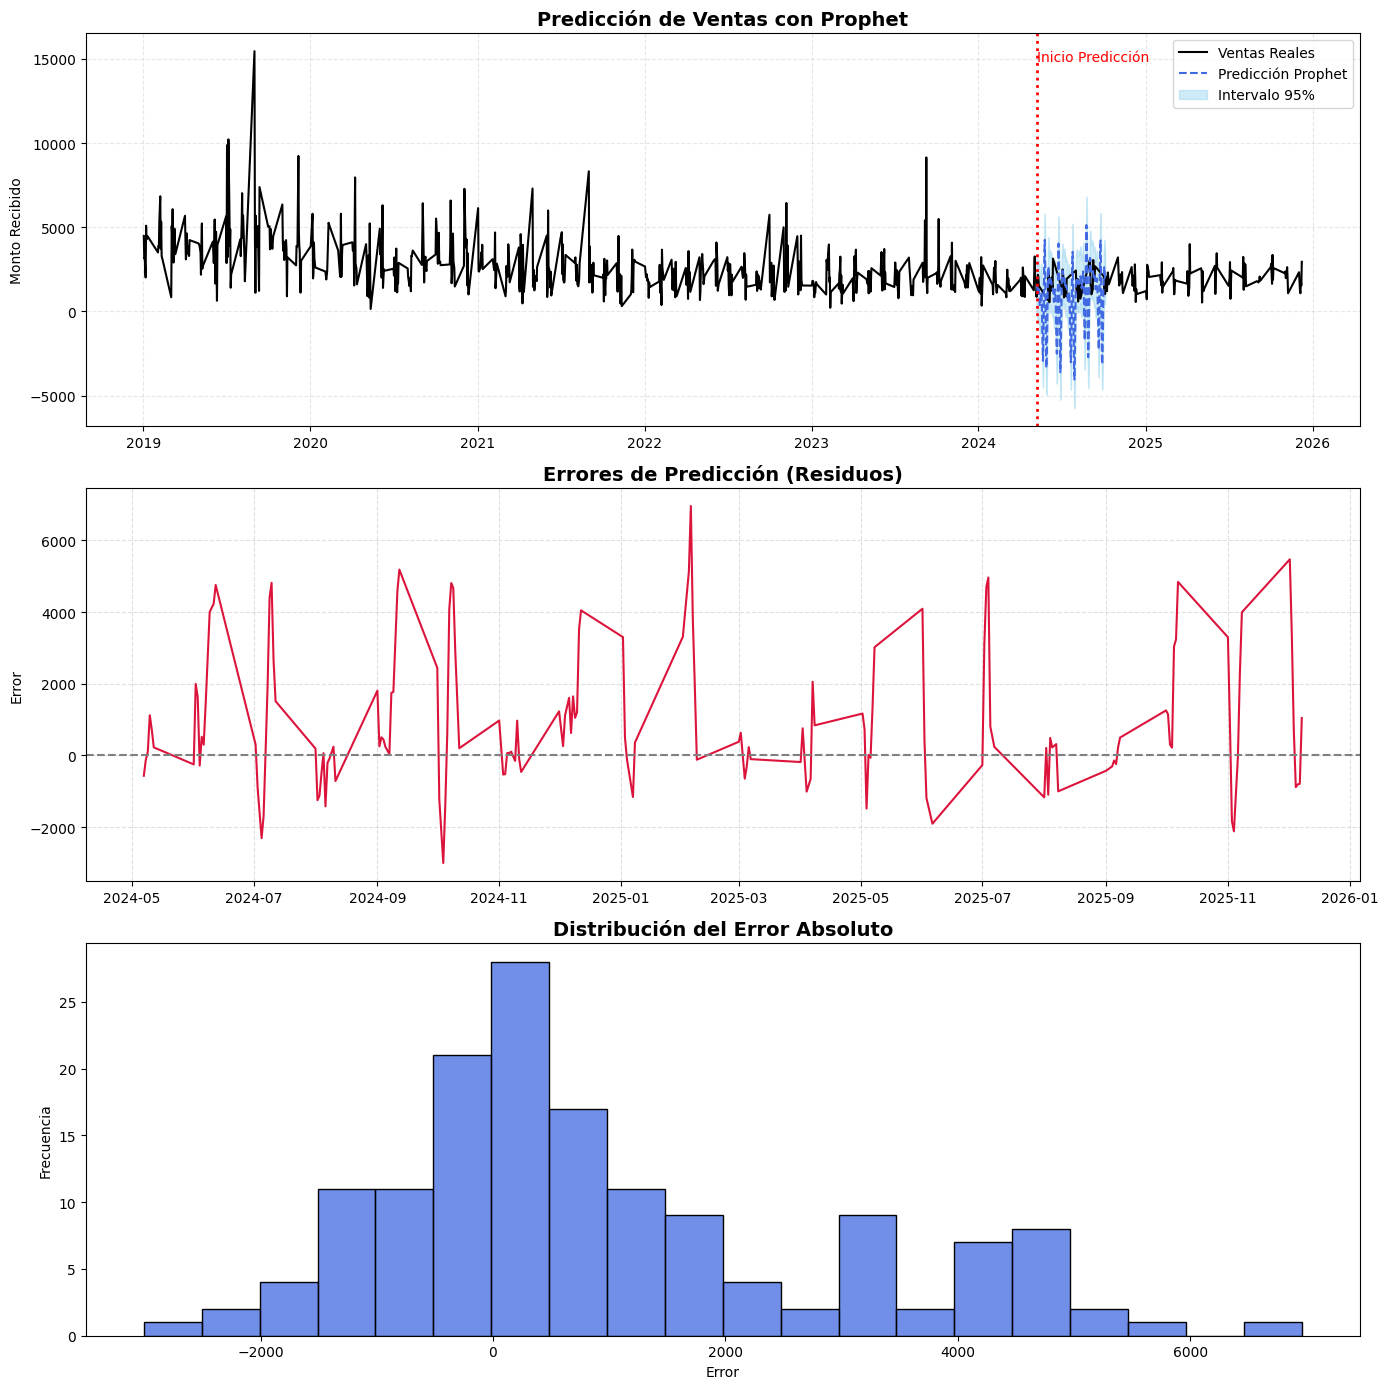

02:18:19 - cmdstanpy - INFO - Chain [1] start processing


✅ Archivo exportado: prediccion_prophet_completa_D.csv


02:18:20 - cmdstanpy - INFO - Chain [1] done processing



### Métricas ###
  Métrica        Valor
0     MAE  6111.456278
1    RMSE  7969.199319
2   sMAPE       40.26%


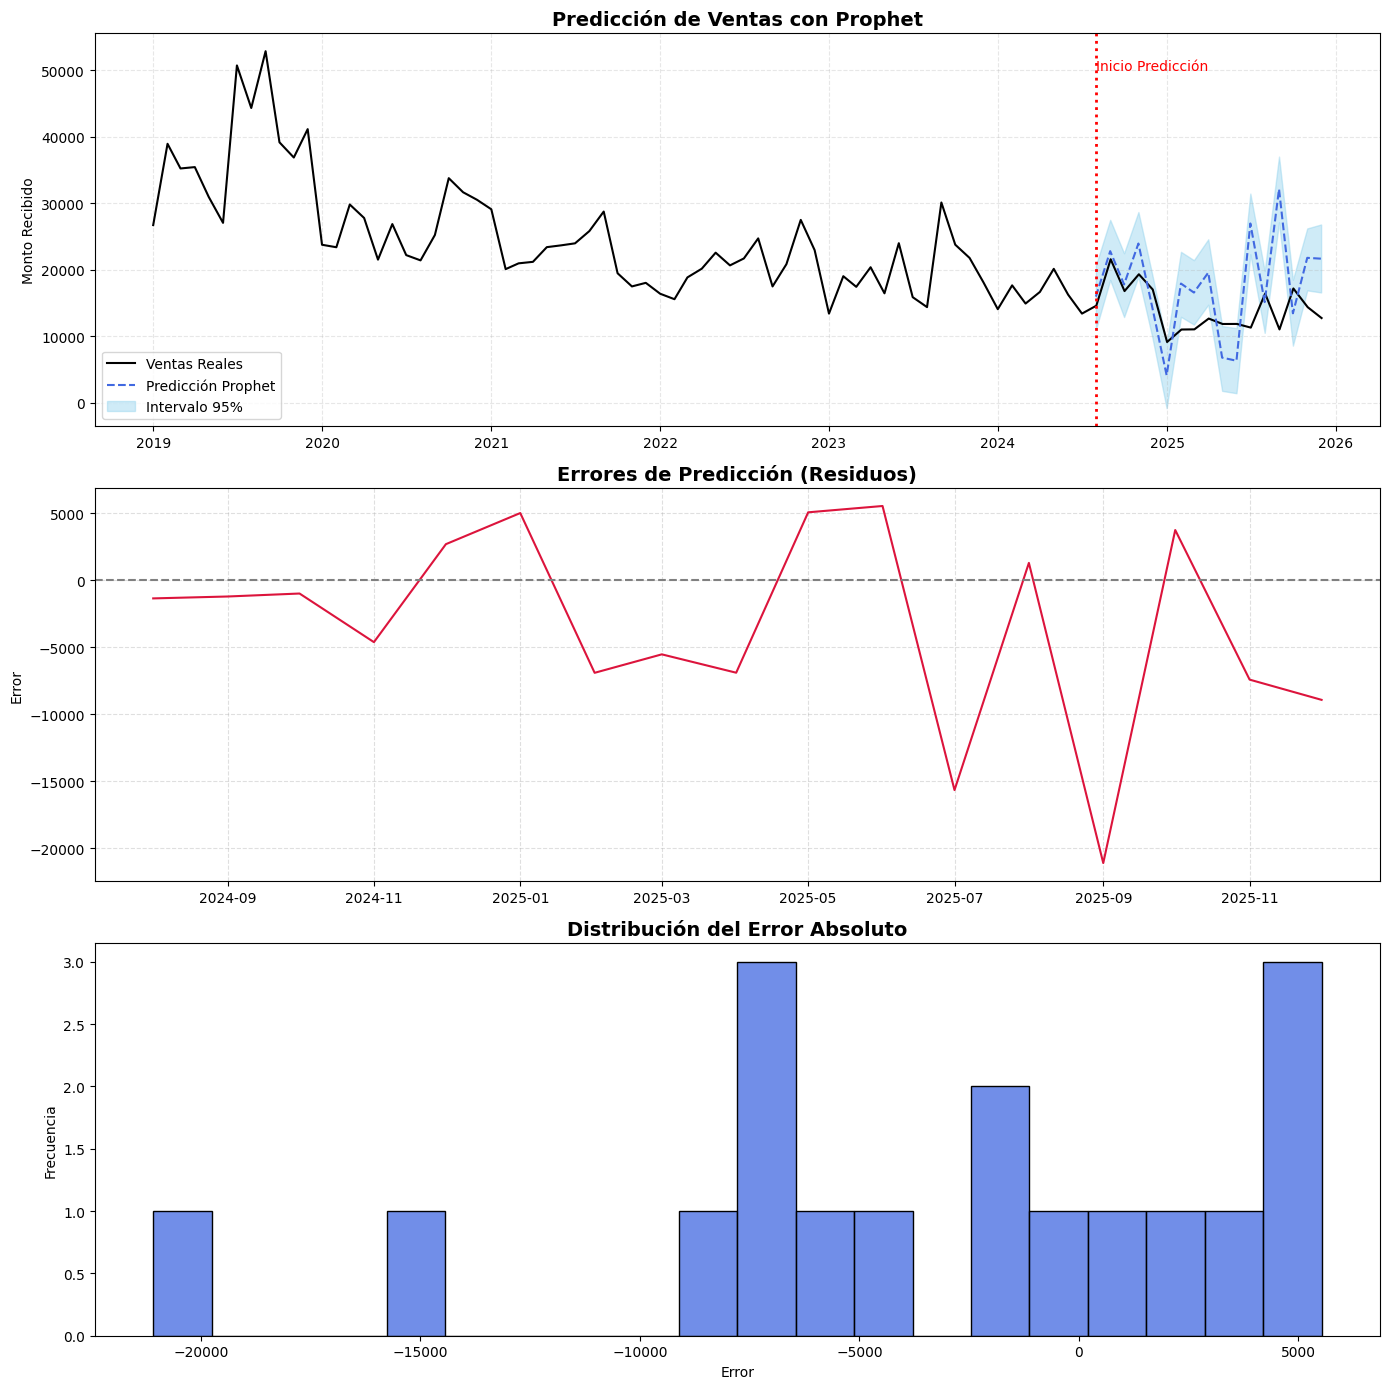

✅ Archivo exportado: prediccion_prophet_completa_M.csv


(<prophet.forecaster.Prophet at 0x2d901abe920>,
            ds         trend    yhat_lower    yhat_upper   trend_lower  \
 0  2019-01-01  39618.536069  27930.020595  37429.533151  39618.536069   
 1  2019-02-01  39017.368869  30496.116362  39885.683098  39017.368869   
 2  2019-03-01  38474.379140  30664.538108  40522.734418  38474.379140   
 3  2019-04-01  37873.211938  33130.496184  43367.475783  37873.211938   
 4  2019-05-01  37291.437226  26313.723135  36015.465711  37291.437226   
 ..        ...           ...           ...           ...           ...   
 79 2025-07-31  16930.218126  10516.937541  19805.262557  16414.521092   
 80 2025-08-31  16818.037914  27135.098682  37002.817277  16242.303955   
 81 2025-09-30  16709.476418   8591.697485  18497.841932  16079.988347   
 82 2025-10-31  16597.296205  16900.888827  26209.216329  15899.294514   
 83 2025-11-30  16488.734709  16589.019228  26802.244474  15726.010632   
 
      trend_upper  additive_terms  additive_terms_lower  addit

In [5]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# --- Métricas ---
def calcular_metricas(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    smape = 100 * np.mean(2 * np.abs(pred - real) / (np.abs(real) + np.abs(pred)))
    metricas = pd.DataFrame({
        'Métrica': ['MAE', 'RMSE', 'sMAPE'],
        'Valor': [mae, rmse, f"{smape:.2f}%"]
    })
    print("\n### Métricas ###")
    print(metricas)
    return metricas

# --- Función principal Prophet ---
def ejecutar_prophet_mejorado(path, freq='D', periodo_pred=30):
    """
    path: CSV con columnas 'fecha' y 'monto_recibido'
    freq: 'D' (diaria) o 'M' (mensual)
    periodo_pred: número de días/meses a predecir
    """
    # 1. Cargar datos
    df = pd.read_csv(path)
    
    # 2. Preparar datos
    df['fecha'] = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
    if freq == 'M':
        df['fecha'] = df['fecha'].dt.to_period('M').dt.to_timestamp()
    
    df = df.groupby('fecha')['monto_recibido'].sum().reset_index()
    df.rename(columns={'fecha': 'ds', 'monto_recibido': 'y'}, inplace=True)
    
    # Tratar nulos e interpolar
    df['y'].replace(0, np.nan, inplace=True)
    df['y'].interpolate(method='linear', inplace=True)
    
    # 3. Dividir train/test
    n = len(df)
    train_size = int(n*0.8)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    
    # 4. Entrenar Prophet
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.1,
        seasonality_mode='additive'
    )
    if freq == 'D':
        m.add_seasonality(name='mensual', period=30.5, fourier_order=5)
    m.fit(train)
    
    # 5. Predicción
    future = m.make_future_dataframe(periods=len(test), freq=freq)
    forecast = m.predict(future)
    
    # Filtrar solo test
    predicciones = forecast.iloc[-len(test):]
    
    # 6. Métricas
    calcular_metricas(test['y'].values, predicciones['yhat'].values)
    
    # 7. Graficar todo en paneles
    fig, axs = plt.subplots(3, 1, figsize=(14, 14))
    
    # Serie completa + predicción + intervalo
    axs[0].plot(df['ds'], df['y'], label='Ventas Reales', color='black')
    axs[0].plot(predicciones['ds'], predicciones['yhat'], '--', label='Predicción Prophet', color='royalblue')
    axs[0].fill_between(predicciones['ds'], predicciones['yhat_lower'], predicciones['yhat_upper'],
                        color='skyblue', alpha=0.4, label='Intervalo 95%')
    axs[0].axvline(df['ds'].iloc[train_size], color='red', linestyle=':', linewidth=2)
    axs[0].text(df['ds'].iloc[train_size], axs[0].get_ylim()[1]*0.9, 'Inicio Predicción', color='red')
    axs[0].set_title('Predicción de Ventas con Prophet', fontsize=14, weight='bold')
    axs[0].set_ylabel('Monto Recibido')
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.3)
    
    # Residuos
    residuos = test['y'].values - predicciones['yhat'].values
    axs[1].plot(test['ds'], residuos, color='crimson')
    axs[1].axhline(0, linestyle='--', color='gray')
    axs[1].set_title('Errores de Predicción (Residuos)', fontsize=14, weight='bold')
    axs[1].set_ylabel('Error')
    axs[1].grid(True, linestyle='--', alpha=0.4)
    
    # Histograma de errores
    sns.histplot(residuos, bins=20, color='royalblue', edgecolor='black', ax=axs[2])
    axs[2].set_title('Distribución del Error Absoluto', fontsize=14, weight='bold')
    axs[2].set_xlabel('Error')
    axs[2].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()
    
    # 8. Exportar CSV
    resultado = pd.DataFrame({
        'ds': test['ds'].values,
        'real': test['y'].values,
        'yhat': predicciones['yhat'].values,
        'yhat_lower': predicciones['yhat_lower'].values,
        'yhat_upper': predicciones['yhat_upper'].values,
        'residuo': residuos
    })
    resultado.to_csv(f'../output/prediccion_prophet_completa_{freq}.csv', index=False)
    print(f"✅ Archivo exportado: prediccion_prophet_completa_{freq}.csv")
    
    return m, forecast, resultado

# --- Uso ---
ejecutar_prophet_mejorado('../output/dataset_venta.csv', freq='D')
ejecutar_prophet_mejorado('../output/dataset_venta.csv', freq='M')
